# Import of python library

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn.cluster
from PIL import Image
import math
import json
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier ,export_graphviz
import pydotplus
import random
from IPython.display import display
import psutil

## Creation of the color bank

In [ ]:

names=["Color name", "RGB", "HEX"]
with open("./colorPalette.csv", "r") as file:
    lines = file.read().splitlines()
    lines = lines[1:]
    for i,line in enumerate(lines):
        line = line.split("\t")
        r = int (line[1].split(",")[0].split("(")[1])
        g = int (line[1].split(",")[1])
        b = int (line[1].split(",")[2].split(")")[0])
       
        line[1] = (r, g, b)
        lines[i] = line
colorBank = pd.DataFrame(lines, columns=names)   

In [ ]:
def distanceCalcul(color1, color2):
    return math.sqrt( (color2[0]-color1[0])**2 + (color2[1]-color1[1])**2 + (color2[2]-color1[2])**2)

def colorNormalisation(paletteColor: pd.DataFrame , color : tuple) -> str:
    distanceMin = math.inf
    
    for index in paletteColor.index:
        distance = distanceCalcul(paletteColor["RGB"][index], color)
        if (distance < distanceMin):
            distanceMin = distance
            colordistancemin = paletteColor["Color name"][index]
    
    return colordistancemin

# print(colorNormalisation(colorPalette, (44, 143,163)))


## Extraction of Images

In [ ]:
rootDirectory = "./flowers"
# for all images the path will be rootDirectory / plantName /file  exemple ./flowers/jpeg-192x192/train/alpine sea holly/11331.jpeg


subdir = []
informationsOnImages = []
for repo, subrepos, files in os.walk(rootDirectory):
    subdir.append(subrepos)
    # filelist.append(files)

print(subdir[0])
for dir in subdir[0]:
  
    # for all images the path will be rootDirectory / plantName /file  exemple ./flowers/jpeg-192x192/train/alpine sea holly/11331.jpeg

    filelist = []
    namelist = []
    for repo, subrepos, files in os.walk("{}/{}/train".format(rootDirectory, dir)):
        namelist.append(subrepos)
        filelist.append(files)

    namelist = namelist[0]
    filelist = filelist[1:]

    # informationsOnImages = { {"name":plantName, "fichier":file, "color":[]} for plantName, file in zip(namelist, filelist)}
    

    for name, files  in zip(namelist, filelist):
            for i, image in enumerate( files) :
                # limite at 10 images by type for the need of the test (end with a 1040 images of 12000)
                if i < 10:                                                              
                    informationsOnImages.append({"size": int(dir[9:]), "name":name, "file":image, "color1":"", "color2": "", "color3": ""})
                else:
                    break
            
datasetImages = pd.DataFrame(informationsOnImages)

datasetImages


Extraction of principal colors

In [ ]:

nb_cluster = 5
for index, row in datasetImages.iterrows():

    imgfile = Image.open(
        "{root}/jpeg-{size}x{size}/train/{type}/{file}".format(
            root = rootDirectory,
            size = row["size"], 
            type = row["name"], 
            file = row["file"]
            )
        )
    
    # extraction of 5 main color
    numarray = np.array(imgfile.getdata(), np.float64)
    clusters = sklearn.cluster.MiniBatchKMeans(n_clusters= nb_cluster)
    clusters.fit(numarray)

    # ordering the colors
    npbins = np.arange(0, nb_cluster + 1)
    histogram = np.histogram(clusters.labels_, bins=npbins)
    palette = clusters.cluster_centers_
    indicesMax = histogram[0].argsort()

    # add the 3 main colors normalized into the datasetImage
    datasetImages.loc[index, "color1"] = colorNormalisation(colorBank, palette[indicesMax[-1]])
    datasetImages.loc[index, "color2"] = colorNormalisation(colorBank, palette[indicesMax[-2]])
    datasetImages.loc[index, "color3"] = colorNormalisation(colorBank, palette[indicesMax[-3]])   
    imgfile.close() 

       
datasetImages.head(15)

## Save the dataset into json file to avoid making the Kmeans each time 


In [ ]:
# save the dataframe to json File to avoid having to execute MinibatchKmeans
datasetImages.to_json(path_or_buf="./data.json", orient="index")

## To load the Dataset from json file 

In [ ]:
# Extract data from json file to load the dataframe with colors
datasetImages = pd.read_json(path_or_buf="./data.json", orient="index")

# Creation of the users class


In [170]:
class user:
    
    def __init__(self, age = None, sex = None, preferredColor=None):
        if age == None:
            self.__age = self.selectAge()
        else: 
            self.__age = age

        if sex == None:
            self.__sex = self.selectSex()
        else: 
            self.sex = sex

        if  preferredColor == None:
            self.__preferredColor = self.preferredColor()
        else:
            self.__preferredColor = preferredColor

        self.__likedImages = pd.DataFrame()
        self.__unlikedImages = pd.DataFrame()
        self.__decisionTree = tree.DecisionTreeClassifier()

    def selectAge(self):
        ok = False
        while not ok:
            age = input("What is your age: ")
            if age.isnumeric():
                age = int(age)
                ok = True
        return age
    def selectSex(self):
        sex = ""
        while sex not in ("M", "F"):
            sex = input("Please select sex (M/F):").upper()
        return sex


    def preferredColor(self):
        print(colorBank["Color name"])
        preferredColor = ""
        while preferredColor not in map(str.lower, colorBank["Color name"].values):
            preferredColor = input("Please select your preferred color in the list above").lower()
        
        return preferredColor

    def addImagesHistory(self, images:pd.DataFrame, notation:list):
        images = images.reset_index()
        
        for index, image in images.iterrows():
            if notation[index] == "y":
                self.__likedImages = self.__likedImages.append(image)
            else:
                self.__unlikedImages = self.__unlikedImages.append(image)
        
                

    def getAge(self):
        return self.__age
    
    def getSex(self):
        return self.__sex

    def getPreferredColor(self):
        return self.__preferredColor

    def getLikedImages(self):
        return self.__likedImages

    def getUnlikedImages(self):
        return self.__unlikedImages    

   

    def trainDecisionTree(self, trainset, results):
        self.__decisionTree = self.__decisionTree.fit(trainset, results)

    def printDecisionTree(self):
        tree.plot_tree(self.__decisionTree)



    def predictLikedImages(self, images):
        prediction = self.__decisionTree.predict(images)
        return prediction 




In [ ]:
new = user()


In [ ]:
trainset = datasetImages.sample(10)

In [ ]:
rootDirectory = "./flowers"
result = []
for index, image in trainset.iterrows():
    
    imgfile = Image.open(
        "{root}/jpeg-{size}x{size}/train/{type}/{file}".format(
            root = rootDirectory,
            size = image["size"], 
            type = image["name"], 
            file = image["file"]
            )
        )
    imgfile.show()
    result.append(input("Do you like this image? (y/n)"))
    imgfile.close()
print(result)

In [ ]:
resultset = pd.DataFrame(result, columns=["favorite"])
# trainset = trainset.drop(["file"], axis=1) 
leName = LabelEncoder()
trainset["name"] = leName.fit_transform(trainset["name"])

leTaille = LabelEncoder()
trainset["size"] = leTaille.fit_transform(trainset["size"])

leColor1 = LabelEncoder()
trainset["color1"] = leColor1.fit_transform(trainset["color1"])

leColor2= LabelEncoder()
trainset["color2"] = leColor2.fit_transform(trainset["color2"])

leColor3 = LabelEncoder()
trainset["color3"] = leColor3.fit_transform(trainset["color3"])


leResult = LabelEncoder()
resultset["favorite"] = leResult.fit_transform(resultset["favorite"])


In [ ]:
# resultset
# trainset
new.trainDecisionTree(trainset, resultset)
new.printDecisionTree()

In [ ]:
print(new.getNewImages())

In [190]:
class recommendationSystem:
    def __init__(self, datasetImages: pd.DataFrame):
        self.listUser = []

        self.datasetImages = datasetImages
        self.LabelEncoder = self.createLabelEncoder()

    def createLabelEncoder(self):
        leName = LabelEncoder()
        leTaille = LabelEncoder()
        leColor1 = LabelEncoder()
        leColor2= LabelEncoder()
        leColor3 = LabelEncoder()
        leResult = LabelEncoder()
        return {
            "name" : leName, 
            "size" : leTaille, 
            "color1" : leColor1, 
            "color2" : leColor2, 
            "color3" : leColor3, 
            "result" : leResult
            }


    def encodeLabels(self, sets:pd.DataFrame):
        sets["name"] = self.LabelEncoder["name"].fit_transform(sets["name"])
        sets["size"] = self.LabelEncoder["size"].fit_transform(sets["size"])
        sets["color1"] = self.LabelEncoder["color1"].fit_transform(sets["color1"])
        sets["color2"] = self.LabelEncoder["color2"].fit_transform(sets["color2"])
        sets["color3"] = self.LabelEncoder["color3"].fit_transform(sets["color3"])

        return sets

    def decodeLabels(self,sets:pd.DataFrame ):
        sets["name"] = self.LabelEncoder["name"].inverse_transform(sets["name"])
        sets["size"] = self.LabelEncoder["size"].inverse_transform(sets["size"])
        sets["color1"] = self.LabelEncoder["color1"].inverse_transform(sets["color1"])
        sets["color2"] = self.LabelEncoder["color2"].inverse_transform(sets["color2"])
        sets["color3"] = self.LabelEncoder["color3"].inverse_transform(sets["color3"])

        return sets

    def encodeResults(self, result):
        return self.LabelEncoder["result"].fit_transform(result)

    def decodeResults(self, result):
        return self.LabelEncoder["result"].inverse_transform(result)



    def createUser(self) -> user:
        newUser = user( age=20, sex="M", preferredColor="red")
        self.askFirstImages(newUser)
        self.listUser.append(newUser)
        return newUser


    def askImages(self, imageslist, client:user):
        rootDirectory = "./flowers"
        result = []
        for index, image in imageslist.iterrows():
            imgfile = Image.open(
                "{root}/jpeg-{size}x{size}/train/{type}/{file}".format(
                    root = rootDirectory,
                    size = image["size"], 
                    type = image["name"], 
                    file = image["file"]
                    )
                )
            
            display(imgfile)
            valid = False
            while not valid:
                    userLike = input("Do you like this image? (y/n)").lower()
                    if (userLike == "y" or userLike == "n"):
                        valid = True
                        result.append(userLike)
         
            imgfile.close()
            # for proc in psutil.process_iter():
            #     if proc.name() == "display":
            #         proc.kill()


        imageslist = self.encodeLabels(imageslist)
        result = self.encodeResults(result=result)
      
        client.trainDecisionTree(trainset = imageslist.drop(["file"], axis=1), results = result)


    def askFirstImages(self, client:user):
        firstImages = self.datasetImages.sample(2)
        self.askImages(imageslist=firstImages, client=client)



            
    def askNewImages(self, client: user):
        imagesPredictedLike = pd.DataFrame()
        imagesPredictedDislike = pd.DataFrame()
        predictedset = []
        for i in range(100):

            newImageset = self.datasetImages.sample(2, ignore_index = True)
            newImageset = self.encodeLabels(newImageset)
            predictedset = client.predictLikedImages(newImageset.drop(["file"], axis=1))
            if any(predictedset):
                break
                
        newImageset = self.decodeLabels(newImageset)
       
        print(any(predictedset))
        for index, image in newImageset.iterrows():
            if predictedset[index] :
                imagesPredictedLike = imagesPredictedLike.append(image)
            else:
                imagesPredictedDislike = imagesPredictedDislike.append(image)
        
        # adding some images labeled as unliked to keep bias 
        imagesPredictedLike =   imagesPredictedLike if imagesPredictedDislike.empty else imagesPredictedLike.append(imagesPredictedDislike.sample(frac=0.1))  
        imagesPredictedLike["size"] = imagesPredictedLike["size"].astype(int)
        
        if imagesPredictedLike["name"].size > 10:
            imagesPredictedLike = imagesPredictedLike.sample(10)
        print(imagesPredictedLike)
        # self.askImages(imageslist=imagesPredictedLike, client=client)

        

## ajouter la back propagation avec les images tagger comme like etc
## ajouter les images dans la liste des imges likes de l'user dans firstImages et newImages
## potentiellement ajouter de la selection pour les premieres images en fonction des autres utilisateurs semblables
## resoudre le probleme de la fermeture des images
## ecrire le rapport 
        

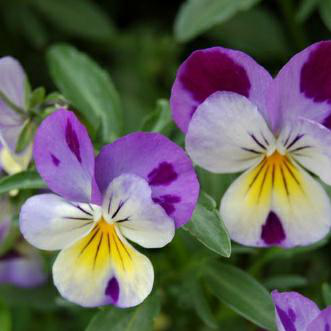

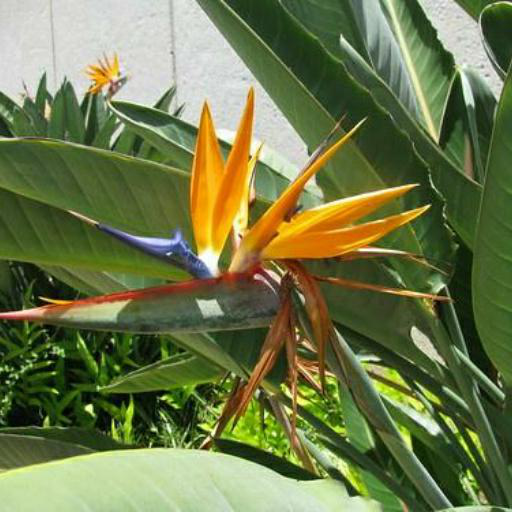

In [191]:
tinder = recommendationSystem(datasetImages=datasetImages)
newuser = tinder.createUser()



In [192]:
tinder.askNewImages(newuser)


KeyboardInterrupt: 

In [ ]:
metrics = +- 1* sexe== + 1* 1/(distance ou 1 si distance==0) + 10*(preferredColor == )

for user in listUsers
    calcul metrics
   if metric >max   
    copain = user
    max = metric

proposer user.likedImages

